# CNN - 고양이,개 이미지 분류

[https://www.kaggle.com/datasets/tongpython/cat-and-dog](https://www.kaggle.com/datasets/tongpython/cat-and-dog) 에서 배포하는 데이터셋

`cat.인덱스번호.jpg`와 `dog.인덱스번호.jpg` 형식으로 개 이미지 12,500개, 고양이 이미지 12,500개로 구성되어 있다.

## #01. 패키지 참조

In [1]:
import os
import helper
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## #02. 데이터셋 준비하기

### 1. 구글 드라이브 연결

Colab의 파일 트리에 `drive`라는 항목이 나타나면 됨

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. 이미지 파일 압축 해제

압축 파일을 구글 드라이브에 업로드 한 상태에서 수행

In [3]:
# 압축파일의 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/CatsAndDogs.zip'

# 압축을 해제할 경로
extract_dir = os.path.join(os.getcwd(), "data")

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 3. 파일 경로 확인

#### 훈련용 데이터셋의 경로

In [4]:
train_cats_dir = os.path.join(extract_dir, 'training_set/cats')
train_dogs_dir = os.path.join(extract_dir, 'training_set/dogs')
print(train_cats_dir)
print(train_dogs_dir)

/content/data/training_set/cats
/content/data/training_set/dogs


#### 검증용 데이터셋의 경로

In [5]:
test_cats_dir = os.path.join(extract_dir, 'test_set/cats')
test_dogs_dir = os.path.join(extract_dir, 'test_set/dogs')
print(test_cats_dir)
print(test_dogs_dir)

/content/data/test_set/cats
/content/data/test_set/dogs


### 4. 각 폴더별로 이미지 파일의 수 확인

In [6]:
print("훈련용 고양이 이미지: %d개" % len(os.listdir(train_cats_dir)))
print("훈련용 개 이미지: %d개" % len(os.listdir(train_dogs_dir)))
print("검증용 고양이 이미지: %d개" % len(os.listdir(test_cats_dir)))
print("검증용 개 이미지: %d개" % len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지: 4001개
훈련용 개 이미지: 4006개
검증용 고양이 이미지: 1012개
검증용 개 이미지: 1013개


### 5. 임의의 이미지 확인

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(25, 10), dpi=100)

for i in range(0, len(ax)):

    dir = train_cats_dir if i == 0 else train_dogs_dir
    files = os.listdir(dir)

    for j in range(0, len(ax[i])):
        file_path = os.path.join(dir, files[j])
        sample = Image.open(file_path)
        ax[i][j].imshow(sample)
        ax[i][j].axis('off')

plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.

> 출력결과를 통해 이미지의 해상도가 모두 다르다는 것을 알 수 있다. 이 경우 입력 데이터의 shape가 모두 상이하기 때문에 학습이 불가능하다. 그러므로 모든 이미지를 균일하게 리사이즈 해야 한다.
>
> 또한 학습, 검증용 이미지가 매우 부족하기 때문에 이미지를 반전, 회전, 색상 변환 등의 방법을 적용하여 학습 데이터를 증강시켜야 한다.

### 6. 이미지 데이터 전처리

#### 이미지 증강

훈련 및 검증용 이미지가 저장되어 있는 폴더는 구분하고자 하는 종속변수의 수 만큼 하위 폴더를 갖는다.

> 개와 고양이로 이진 분류를 해야 하는 경우 2개의 하위 폴더가 필요하다는 의미(cats, dogs)

`ImageDataGenerator`는 훈련용 이미지가 저장되어 있는 폴더, 검증용 이미지가 저장되어 있는 폴더까지만 전달한다.

`ImageDataGenerator`가 하위 폴더를 식별하여 그 안의 `cats`와 `dogs` 폴더 안의 항목들을 읽어들인다.

In [8]:
extract_dir

'/content/data'

In [9]:
training_dir = os.path.join(extract_dir, "training_set")
test_dir = os.path.join(extract_dir, "test_set")

train_datagen = ImageDataGenerator( rescale = 1.0/255 )
test_datagen = ImageDataGenerator( rescale = 1.0/255 )

train_set = train_datagen.flow_from_directory(training_dir,
                                      classes=['cats', 'dogs'],
                                      batch_size=20,            # 이미지를 증강시킬 배수
                                      class_mode='binary',      # 이진분류용임을 명시
                                      target_size=(150, 150))   # 변환될 이미지 해상도

test_set = test_datagen.flow_from_directory(test_dir, classes=['cats', 'dogs'], batch_size=20,  class_mode='binary', target_size=(150, 150))

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## #03. 모델 개발

### 모델 정의

In [10]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      1216      
                                                                 
 batch_normalization (Batch  (None, 150, 150, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        1

### 학습하기

In [11]:
start = dt.datetime.now()

result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

end = dt.datetime.now()

delta = end - start

"총 학습 소요 시간: %d(초)" % delta.seconds

Epoch 1/500
401/401 [==============================] - 19s 35ms/step - loss: 0.9768 - acc: 0.6367 - val_loss: 12.3258 - val_acc: 0.5403 - lr: 0.0010
Epoch 2/500
401/401 [==============================] - 14s 35ms/step - loss: 0.5470 - acc: 0.7137 - val_loss: 0.7279 - val_acc: 0.7029 - lr: 0.0010
Epoch 3/500
401/401 [==============================] - 14s 35ms/step - loss: 0.4928 - acc: 0.7600 - val_loss: 0.5922 - val_acc: 0.6891 - lr: 0.0010
Epoch 4/500
401/401 [==============================] - 14s 35ms/step - loss: 0.4383 - acc: 0.7975 - val_loss: 1.9639 - val_acc: 0.5917 - lr: 0.0010
Epoch 5/500
401/401 [==============================] - 14s 34ms/step - loss: 0.3840 - acc: 0.8305 - val_loss: 0.5583 - val_acc: 0.7341 - lr: 0.0010
Epoch 6/500
401/401 [==============================] - 14s 35ms/step - loss: 0.3269 - acc: 0.8562 - val_loss: 0.7734 - val_acc: 0.7316 - lr: 0.0010
Epoch 7/500
401/401 [==============================] - 14s 34ms/step - loss: 0.2807 - acc: 0.8811 - val_loss: 0

'총 학습 소요 시간: 144(초)'

## #04. 학습 결과 평가

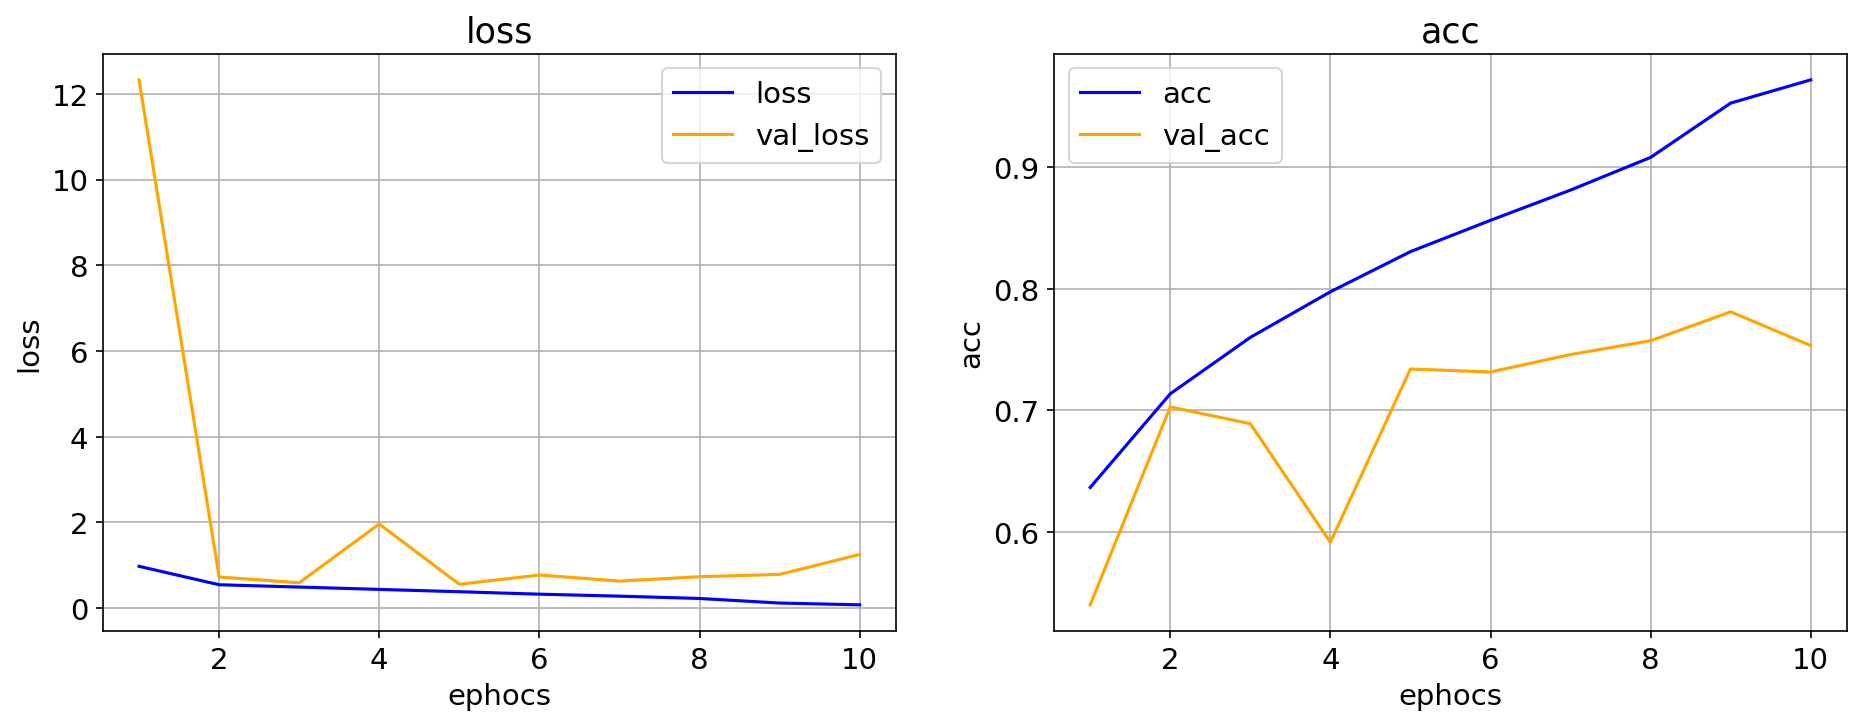

401/401 [==============================] - 11s 27ms/step - loss: 0.3240 - acc: 0.9324
최종 훈련 손실률: 0.323963, 최종 훈련 정확도: 0.932417
102/102 [==============================] - 3s 28ms/step - loss: 1.2527 - acc: 0.7533
최종 검증 손실률: 1.252670, 최종 검증 정확도: 0.753337


In [12]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(train_set)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(test_set)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #05. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과를 산정

In [13]:
pred = model.predict(train_set)
data_count, case_count = pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
pred[0]

401/401 [==============================] - 11s 27ms/step
8005개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([0.7723975], dtype=float32)

In [14]:
pred_result = np.round(pred)
pred_result = pred_result.flatten()
pred_result

array([1., 0., 1., ..., 0., 1., 1.], dtype=float32)

In [19]:
row = 5
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row*col
length = len(train_set)

for i in range(0, size):
    img, label = train_set.next()
    ax[i//col][i%col].imshow(img[0])
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label[0], pred_result[i]))
    ax[i//col][i%col].axis('off')

plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.